# Esercitazione 2

Nella cartella di questa esercitazione ci sono:
- I file *.h*, *.cpp*, *.x* e *.input* delle parti:
    1. __integral__.
    2. __RandomWalk__.
- I file di output della prima parte:
    1. `uniform.dat` .
    2. `importance.dat` .
- I file di output della seconda parte: `RandomWolk.dat` .
- Un `makefile`.
- I file di input per la classe __random__.

<img src="Menu.png">

Questa esercitazione è divisa in:
1. Integrale Monte Carlo.
2. Random walks.

Prima di compilare i programmi bisogna lanciare i seguenti comandi per includere automaticamente le librerie `random` e `BlockAnalisys`.

```bash
cd .. #Vado nella cartella precedente dove c'è setup.sh
source setup.sh
```

In questa eserecitazione è utilizzata la libreria `armadillo` quindi bisogna includerla, se non avviene già in maniera automatica.

Questi comandi servono ad importare le librerie necessarie per il notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 1 Integrale Monte Carlo

L'integrazione Monte Carlo consiste nel stimare l'integrale di una funzione $f(x)$ come limite di una sommatoria, cioè
$$
I=\int_a^b f(x)\,dx= (b-a)\lim_{N\to+\infty}\frac{1}{N}\sum_{i=0}^Nf(x_i)=(b-a)\langle f\rangle_{[a,b]}
$$

Quindi se utilizziamo $N\to\infty$ elementi abbiamo che:
$$
I\approx (b-a)\frac{1}{N}\sum_{i=0}^N f(x_i)
$$

Definiamo la funzione $f(x)$ come $f(x)=g(x)\,p(x)$ nel dominio $\Omega$, dove:
- $g(x)$ è una funzione.
- $p(x)$ è una distribuzione di probabilità, quindi è definita non negativa ed e normalizzata a $1$.

Così l'integrale di partenza diventa:
$$
I=\int_\Omega g(x)\,p(x)\,dx=\langle g \rangle_{\Omega}
$$

Definiamo:
$$
G_N=\frac{1}{N}\sum_{i=0}^Ng(x_i)
$$

Notiamo che  $G_N$ stima $I$ con un errore $\varepsilon=\frac{\sigma_I}{\sqrt{N-1}}$.

Utilizzeremo questo metodo per stimare l'integrale:
$$
I=\int_0^1 \frac{\pi}{2} \cos{\left(\frac{\pi}{2}\,x\right)}\,dx
$$

Per stimare, l'integrale estraiamo $M=1'000'000$ numeri con diverse distribuzioni di probabilità per avere altrettanti valori di $g(x)$.  Dividiamo i vlaori di $g(x)$ in $N=100$ blocchi e per ciascun blocco calcoliamo la media.  Calcoliamo la media e la varianza $\sigma_I^2$ delle medie ottenute, per ottenere le stime dell'integrale $I$ ed il suo errore $\varepsilon$.

In [8]:
#Definisco la funzione da integrare
def f(x):
    return np.pi/2*np.cos(np.pi/2*x)

Questo integrale lo possiamo risolvere analiticamente per verificare i nostri risultati: $I=1$.

### 1.1 Distribuzione Uniforme

Iniziamo utilizzando la distribuzione di probabilità uniforme, $p(x)=\frac{1}{b-a}$.

Nel caso in esame abbiamo:
- $p(x)=1$ .
- $g(x)=\frac{\pi}{2} \, \cos\left(\frac{\pi}{2}\,x\right)$ .

La nostra stima diventa:
$$
I\approx \frac{1}{N}\sum_{i=0}^Ng(x_i)=\frac{1}{N}\sum_{i=0}^N\frac{\pi}{2}\,\cos{\left(\frac{\pi}{2}\,x_i\right)}
$$

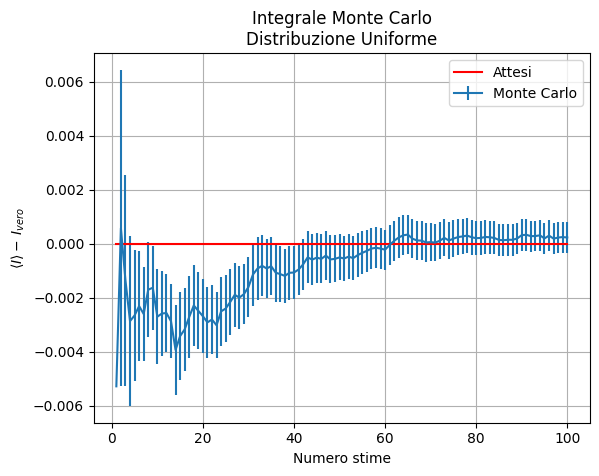

In [2]:
#Carica dati
data=np.loadtxt("uniform.dat")
#Valori dell'ascissa

#Grafico con errore
plt.errorbar(data[:,0], data[:,2],yerr=data[:,3],label="Monte Carlo")
plt.plot(data[:,0],np.zeros(100),label="Attesi",color="red")
#Parte estetica
plt.xlabel("Numero stime")
plt.ylabel(r"$\langle I \rangle -\, I_{vero}$")
plt.title(f"Integrale Monte Carlo\nDistribuzione Uniforme")
plt.legend()
plt.grid(True)

plt.show()

Riusciamo ad ottenere dei risultati compatibili con il valore vero, però questo metodo può dimostrarsi inefficace per funzioni più complesse o in spazi con svariete dimensioni.

### 1.2 Importance Sampling

Possiamo trovare delle distribuzioni di probabilità che funzionino meglio?

Prendiamo in considerazione un'altra distribuzione $d(x)$, ignota.  Se moltiplichiamo e dividiamo l'integranda per questa distribuzione teniamo invariato il risultato dell'integrale, ma abbiamo che:

$$
I=\int_\Omega\left[ \frac{g(x)\,p(x)}{d(x)} \right]\,d(x)\,dx=\left\langle \frac{g(x)\,p(x)}{d(x)} \right\rangle_\Omega
$$

Ciò vuol dire che posso usare una distribuzione più comoda per campionare il mio dominio.

Usando $d(x)=\frac{g(x)\,p(x)}{I}$, abbiamo:

$$
I=\frac{1}{N}\sum\left[\frac{g(x)\,p(x)}{g(x)\,p(x)}\right]\cdot I
$$

Notiamo che questa è un'identità quindi, con questa distribuzione, qualsiasi estrazione mi restituisce il valore di $I$.  Questa distribuzione riscontra un problema visto che per stimare $I$ dovremmo già sapere quanto vale.

Grazie a queste considerazioni possiamo provare ad usare funzioni semplici da integrare, che approssimino al meglio la funzione in esame, infine le normalizioamo per vedere se sono distribuzioni più efficienti.

Facciamo lo sviluppo in __serie di Taylor al primo ordine__ della funzione che vogliamo integrare, per non fare annullare la derivata prima scegliamo di svilupparla intorno ad $1$:
$$
f(x)=\frac{\pi}{2}\, \cos\left(\frac{\pi}{2}\,x\right)\approx \frac{\pi^2}{4}-\frac{\pi^2}{4}x
$$

In [10]:
#Definisco la funzione che approssima
def taylor(x):
    return (np.pi/2)**2*(1-x)

Proviamo a confrontare le due funzioni.

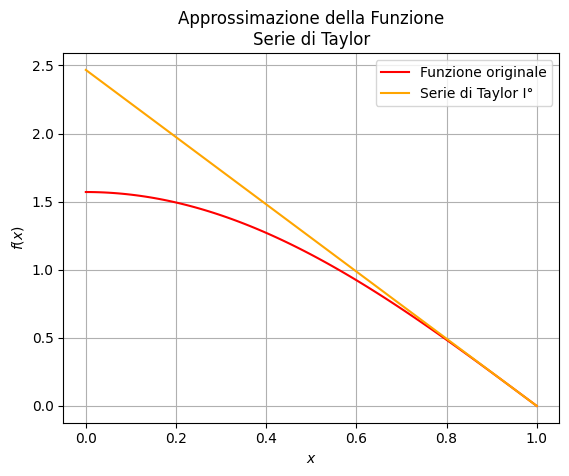

In [11]:
#Creo una list di ascisse
x=np.linspace(0,1,100)

#Plotto i due grafici
plt.plot(x,f(x),label="Funzione originale",color="red")
plt.plot(x,taylor(x),label="Serie di Taylor I°",color="orange")

#Parte estetica
plt.grid(True)
plt.legend()
plt.title(f"Approssimazione della Funzione\nSerie di Taylor")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")

plt.show()

Si vede che la serie di Taylor approssima molto bene l'andamento della funzione intorno ad $1$ e indica solo l'andamento generale per il resto.

Integrando la funzione ottenuta abbiamo:
$$
\int_0^1\frac{\pi^2}{4}\,(1-x)\,dx=\frac{\pi^2}{8}
$$

Adesso possiamo definire la distribuzione del campionamento e la funzione da campionare:
$$
d(x)=2\,(1-x)
$$
$$
\frac{g(x)\,p(x)}{d(x)}=\frac{\pi\,\cos\left(\frac{\pi}{2}\,x\right)}{4\,(1-x)}
$$

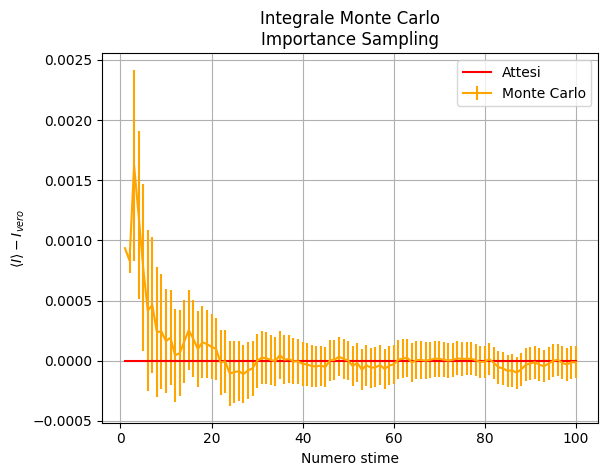

In [3]:
#Carica dati
data=np.loadtxt("importance.dat")

#Grafico con errore
plt.errorbar(data[:,0], data[:,2],yerr=data[:,3],label="Monte Carlo",color="orange")
plt.plot(data[:,0],np.zeros(100),label="Attesi",color="red")
#Parte estetica
plt.xlabel("Numero stime")
plt.ylabel(r"$\langle I \rangle -I_{vero}$")
plt.title(f"Integrale Monte Carlo\nImportance Sampling")
plt.legend()
plt.grid(True)

plt.show()

Anche in questo caso abbiamo trovato risultati compatibili con il valore vero.

### 1.3 Confronto

Adesso vediamo un confronto tra le due diverse distribuzioni.

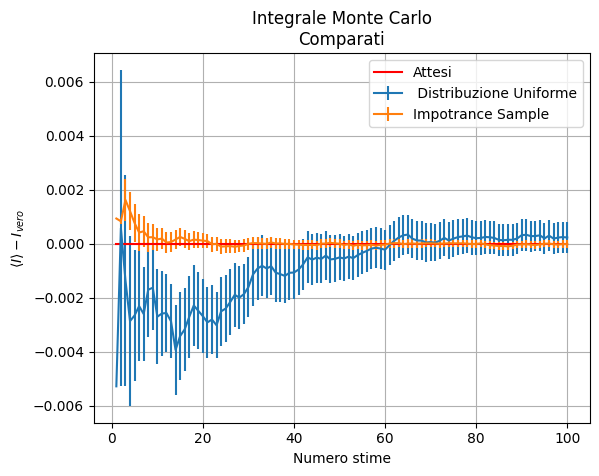

In [13]:
#Carica dati
data=np.loadtxt("uniform.dat")
data1=np.loadtxt("importance.dat")
#Valori dell'ascissa
x=np.array([i+1 for i in range(100)])

#Grafico con errore
plt.errorbar(data[:,0], data[:,2],yerr=data[:,3],label=" Distribuzione Uniforme")
plt.errorbar(data1[:,0], data1[:,2],yerr=data1[:,3],label="Impotrance Sample")
plt.plot(data[:,0],np.zeros(100),label="Attesi",color="red")
#Parte estetica
plt.xlabel("Numero stime")
plt.ylabel(r"$\langle I \rangle-I_{vero} $")
plt.title(f"Integrale Monte Carlo\nComparati")
plt.legend()
plt.grid(True)

plt.show()

Notiamo che entrambi i metodi arrivano allo stesso risultato, però l'importance sampling risulta più preciso ed accurato rispetto a quello che usa la semplice distribuzione uniforme.

## 2 Random Walks

I __random walks__, o *cammini aleatori*, sono un formalismo matematico che consiste in traiettorie di passi casuali.  I RW possono essere di vari tipi i due che prenderemo in esame saranno sempre $3D$ ma con un movimento differente:
1. Su un reticolo.
2. Libero di muoversi nello spazio.

La varianza della posizione ha un andamento lineare da $N$, quindi ci aspettiamo che $\sqrt{\langle |r_N|^2\rangle_{RW}}$ vada come $\sqrt{N}$.

### 2.1 Reticolo

Iniziamo con il reticolo: i passi possono essere soltanto lungo i tre assi ed ogni passo deve essere per forza di un'unità.  Nel grafico possiamo vedere il nostro risultato ed un andamento $\sim\sqrt{N}$.

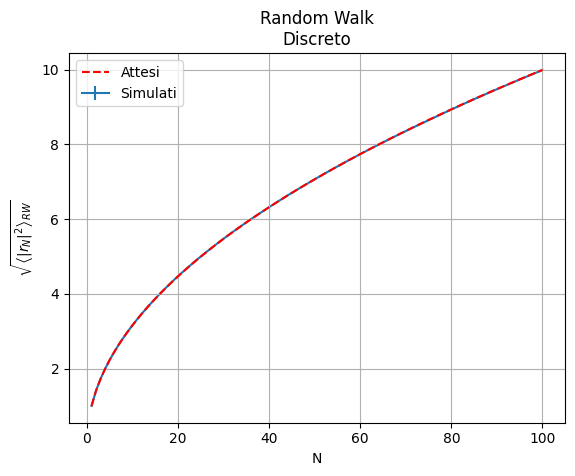

In [21]:
#Carico dati da file e inizializzo le ascisse
data=np.loadtxt("RandomWalk.dat")
dim=np.shape(data)[0]
x=np.linspace(1,dim,dim)

#Faccio un fit dei dati
def my_func(x,k):
    return k*np.sqrt(x)
popt, pcov=curve_fit(my_func,x[1:],data[1:,0],sigma=data[1:,2])

#Plotto i dati
plt.errorbar(x[:],data[:,0],yerr=data[:,2],label="Simulati",zorder=1)
plt.plot(x,my_func(x,popt),color="red",label="Attesi",linestyle="dashed",zorder=2)

#Estetica
plt.title(f"Random Walk\nDiscreto")
plt.xlabel("N")
plt.ylabel(r"$\sqrt{\left\langle|r_N|^2\right\rangle_{RW}}$")
plt.legend()
plt.grid(True)

plt.show()

Da questo grafico possiamo intuire che i due andamentri andamenti sono simili però non sono apprezzabili gli errori, quindi non possiamo sapere se effettivamente sono compatibili.  Proviamo a graficare la distanze tra le due curve.

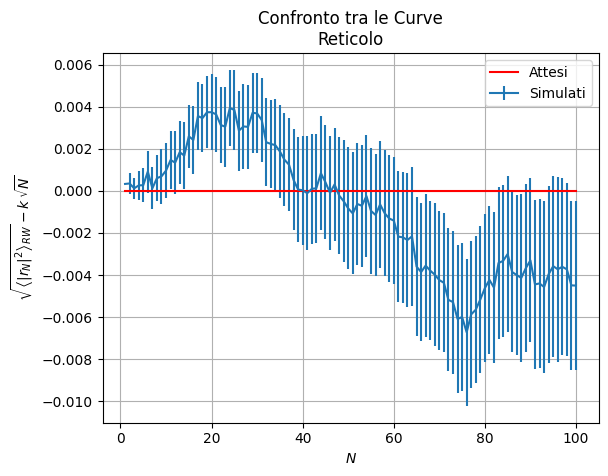

In [24]:
plt.errorbar(x,data[:,0]-my_func(x,popt),yerr=data[:,2],label="Simulati")
plt.plot(x,np.zeros(dim),label="Attesi",color="red")

#Parte estetica
plt.grid(True)
plt.legend()
plt.title(f"Confronto tra le Curve\nReticolo")
plt.xlabel(r"$N$")
plt.ylabel(r"$\sqrt{\left\langle |r_N|^2 \right\rangle_{RW}}-k\,\sqrt{N}$")

plt.show()

Adesso possiamo vedere che i risultati ottenuti sono compatibili con l'andamento desiderato.  Osserviamo che l'errore sulla misura aumenta con il numero di step fatti, infatti più passi si fanno maggiore sarà l'incertezza sulla posizione.

### 2.2 Continuo

Adessao possiamo fare dei passi di lunghezza fissata ma in qualsiasi direzione nello spazio.  Proviamo a vedere se anche in questo caso l'incertezza sulla posizione segue l'andamento $\sim\sqrt{N}$.

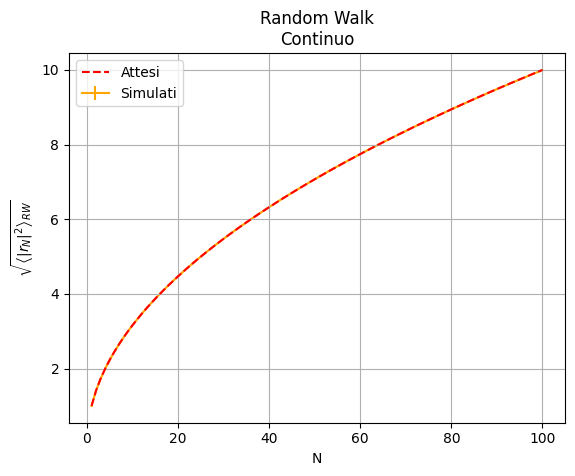

In [30]:
#Faccio un fit dei dati
cpopt, pcov=curve_fit(my_func,x[1:],data[1:,1],sigma=data[1:,3])

#Plotto i dati
plt.errorbar(x,data[:,1],yerr=data[:,3],label="Simulati",color="orange",zorder=1)
plt.plot(x,my_func(x,cpopt),color="red",label="Attesi",zorder=2,linestyle="dashed")

#Estetica
plt.title(f"Random Walk\nContinuo")
plt.xlabel("N")
plt.ylabel(r"$\sqrt{\left\langle|r_N|^2\right\rangle_{RW}}$")
plt.legend()
plt.grid(True)

plt.show()

Anche in questo caso sembrerebbe che la nostra simulazione segua l'andamento voluto però possiamo vedere nel dettaglio la distanza tra le curve.

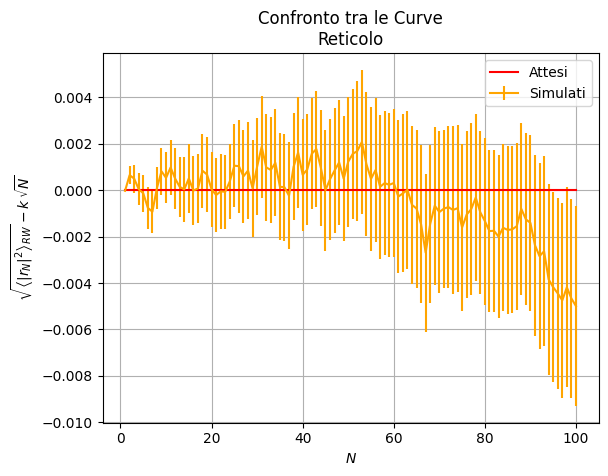

In [35]:
plt.errorbar(x,data[:,1]-my_func(x,cpopt),yerr=data[:,3],label="Simulati", color="orange")
plt.plot(x,np.zeros(dim),label="Attesi",color="red")


#Parte estetica
plt.grid(True)
plt.legend()
plt.title(f"Confronto tra le Curve\nReticolo")
plt.xlabel(r"$N$")
plt.ylabel(r"$\sqrt{\left\langle |r_N|^2 \right\rangle_{RW}}-k\,\sqrt{N}$")

plt.show()

Osservando il grafico possiamo concludere che pure in questo caso l'incertezza segue l'andamento di $\sim\sqrt{N}$.  Come osservato nel caso precedente anche in questo si osserva un errore che aumenta con la lunghezza del cammino, infatti anche in questo caso abbiamo un aumento delle fluttuazioni delle posizioni lungo il percorso.